In [16]:
import numpy as np
import pandas as pd

In [ ]:
from apply_clustering import ClusteringApplier
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from numpy.random import permutation
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

def get_feature_importances(my_feature_set, df_explainable, df_observable_distances, K=100):
    feature_combinations = []
    ([[feature_combinations.append(np.array(c)) for c in combinations(np.arange(len(my_feature_set)), i)] for i in range(1, len(my_feature_set)+1)])
    
    _, df_explainable_distances = ClusteringApplier.calculate_pairwise_distances(
        df_explainable.loc[:, my_feature_set], my_feature_set, 'correlation',
    )

    X = df_explainable_distances.loc[:, my_feature_set].to_numpy()
    y = df_observable_distances.to_numpy()
    model = LinearRegression()
    model.fit(X,y)
    y_pred = model.predict(X)
    R2 = explained_variance_score(y_true=y, y_pred=y_pred)
    feature_importances = defaultdict(lambda: 0.)

    i = 0
    for cols in feature_combinations:
        for k in range(K):
            permuted_X = X.copy()
            for col_i in cols:
                permuted_X[:, col_i] = permutation(permuted_X[:, col_i])
            y_pred = model.predict(permuted_X)
            feature_importances[i] += explained_variance_score(y_true=y, y_pred=y_pred)
        i += 1

    i = 0
    for cols in feature_combinations:
        feature_importances[i] = max(0, R2 - (feature_importances[i]/K))
        i += 1
        
    adj_sum = sum(feature_importances.values())
    for key, val in feature_importances.items():
        feature_importances[key] = val / adj_sum

    assert np.isclose(sum(feature_importances.values()), 1)

    def human_readable(_dict: dict) -> dict:
        return {str([str(a) for a in np.array(my_feature_set)[feature_combinations[k]]]):v for k, v in _dict.items()}
    
    human_readable_dict = human_readable(feature_importances)
    fig_1 = plt.figure(figsize=(10, 5))
    ax1 = sns.barplot(human_readable_dict)
    ax1.axes.xaxis.set_tick_params(rotation=90)

    revised_feature_importances = defaultdict(lambda: 0)
    i = 0
    for cols in feature_combinations:
            
        a = feature_importances[i]
        b = sum([feature_importances[j] for j in cols])
        revised_feature_importances[i] += a/b-1

        i += 1

    fig_2 = plt.figure(figsize=(10, 5))
    ax2 = sns.barplot(human_readable(revised_feature_importances))
    ax2.axes.xaxis.set_tick_params(rotation=90)

    return fig_1, fig_2


In [18]:
base_size = 100

In [19]:
data = np.random.normal(loc=0, scale=1, size=(base_size, 6))

In [20]:
_a = np.random.normal(loc=0.3, scale=0.1, size=(base_size, 1)).flatten()
_b = np.random.normal(loc=0.4, scale=0.1, size=(base_size, 1)).flatten()
_c1 = np.random.normal(loc=0.5, scale=0.1, size=(base_size, 1)).flatten()
_c2 = np.random.normal(loc=0.4, scale=0.2, size=(base_size, 1)).flatten()
_d1 = np.random.normal(loc=0.3, scale=0.1, size=(base_size, 1)).flatten()
_d2 = np.random.normal(loc=0.2, scale=0.05, size=(base_size, 1)).flatten()

In [21]:
a = (data[:, 0] > _a) * 1.
b = (data[:, 1] < _b) * 1.
c = np.minimum(data[:, 0] > _c1, data[:, 2] > _c2) * 1.
#d = data[:, 0] - _d1 #np.minimum(data[:, 4] > _d1, data[:, 5] < _d2) * data[:, 5]
#e = data[:, 1] * _d2 #np.minimum(data[:, 1] > _d1, data[:, 5] < _d2) * data[:, 4]

In [22]:
a.sum()/base_size, b.sum()/base_size, c.sum()/base_size, #d.sum()

(np.float64(0.4), np.float64(0.65), np.float64(0.11))

In [23]:
df_explainable = pd.DataFrame(data)
df_explainable.head()

,0,1,2,3,4,5
0,0.893059,1.249139,0.932034,0.057231,0.815929,0.180562
1,1.250533,-1.325175,0.566640,-0.132484,0.571153,0.757656
2,-0.422916,-0.902109,1.244345,-0.541799,0.725695,-0.543040
3,-0.821960,0.826046,-0.650755,0.766120,1.025277,0.147691
4,-1.225108,-2.450132,0.574618,-0.646191,1.457628,-2.095252


In [24]:
explaining_features = list(df_explainable.columns)

In [25]:
df_observable = pd.DataFrame({
    'a': a,
    'b': b,
    'c': c,
    #'d': d,
    #'e': e
})
observed_features = list(df_observable.columns)

In [26]:
df_observable.head()

,a,b,c
0,1.0,0.0,1.0
1,1.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,0.0
4,0.0,1.0,0.0


In [27]:
df_observable = df_observable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
df_explainable = df_explainable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

In [28]:
df_explainable.loc[:, 'Index'] = df_explainable.index
df_observable.loc[:, 'Index'] = df_observable.index

index_name = 'Index'

{'n_clusters': 7, 'knee': np.int64(2), 'elbow': np.int64(2)}


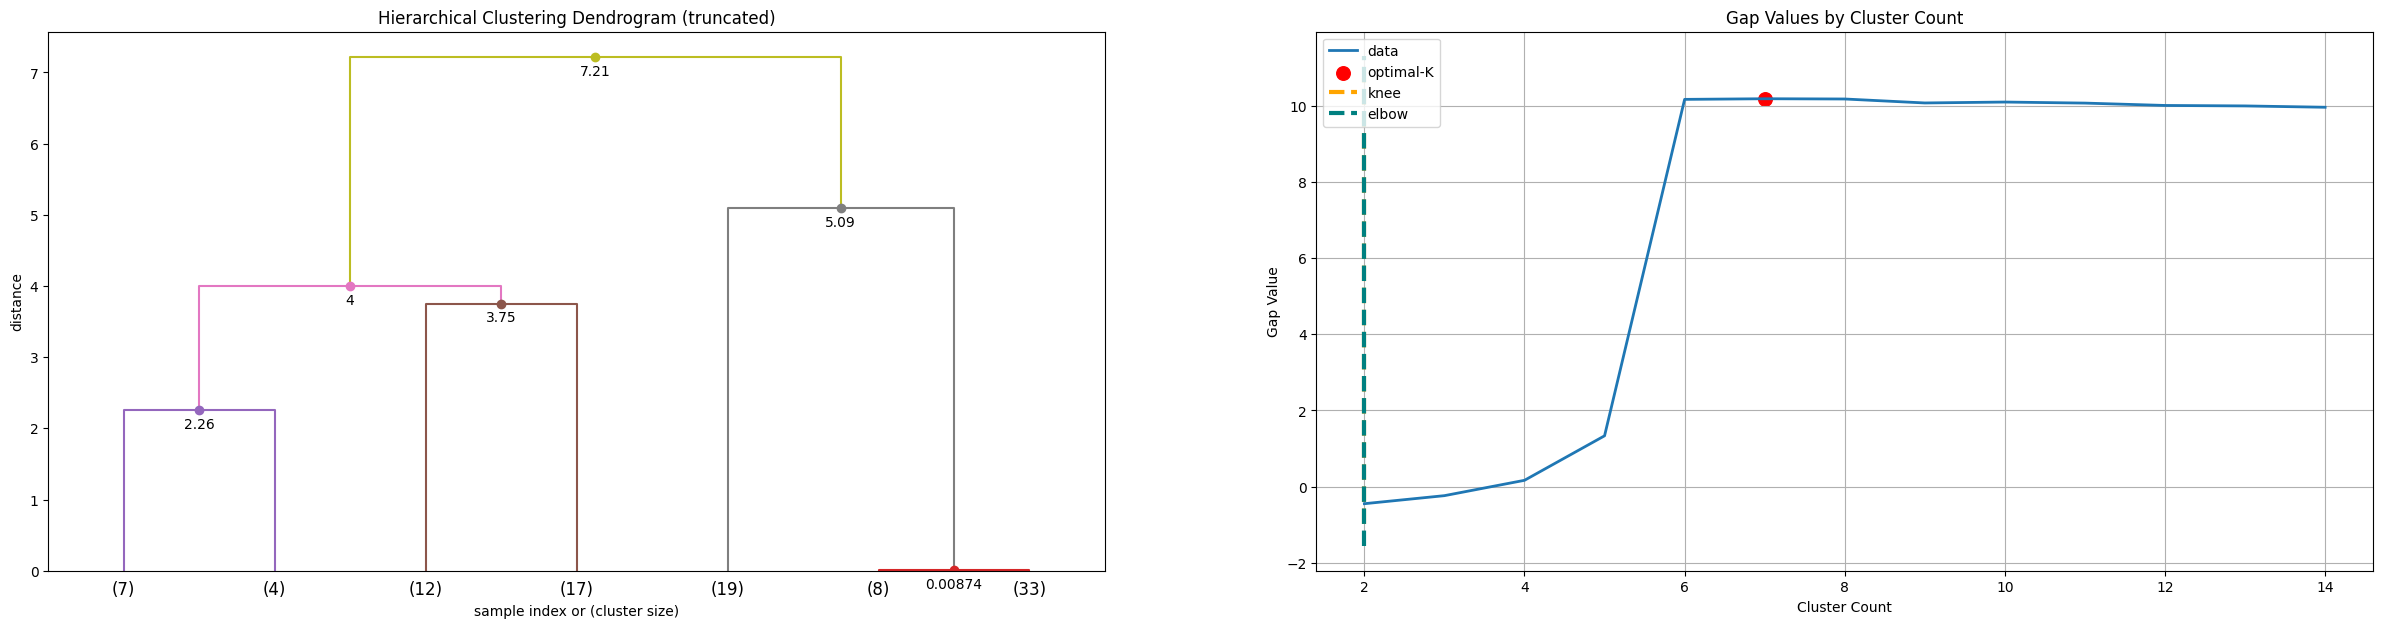

In [30]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

preparation_result = DataPreparator.prepare_data(
    use_config=False,
    df_observable=df_observable,
    df_explainable=df_explainable,
    distortion_mean=0.,
    distortion_std=0.001,
    observed_features=observed_features,
    explaining_features=explaining_features,
    nn_imputation_k=10,
    group_name=index_name
)
optimal_number_of_clusters = ClusteringApplier.draw_gap_statistic_plot(
    use_config=False, df_observable=preparation_result['observable_df'],
    observed_features=observed_features,
    gap_statistic_cluster_range=15
)
print(optimal_number_of_clusters)

  0%|          | 0/57 [00:00<?, ?it/s]

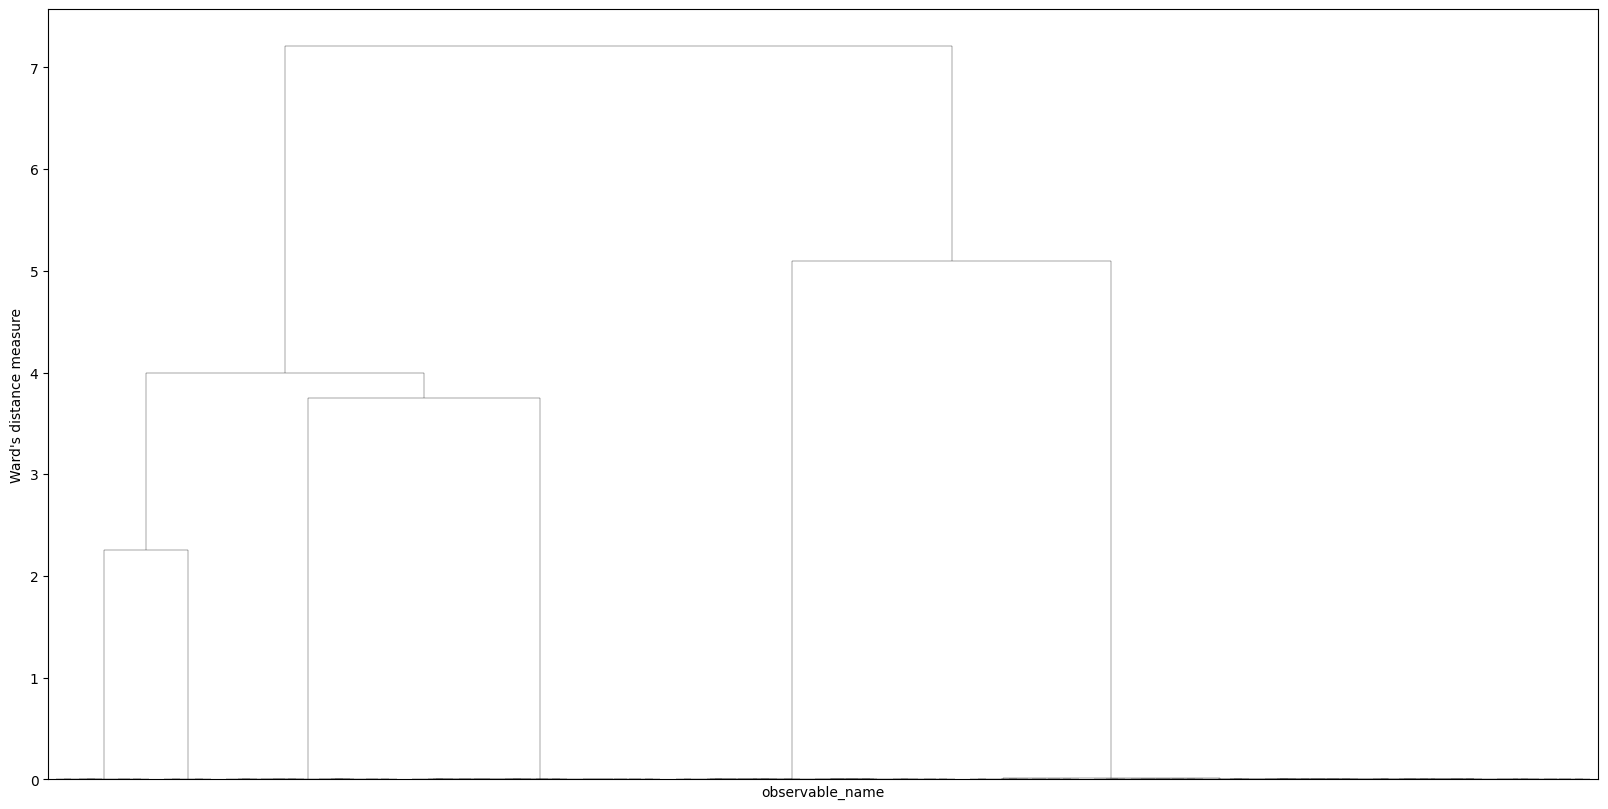

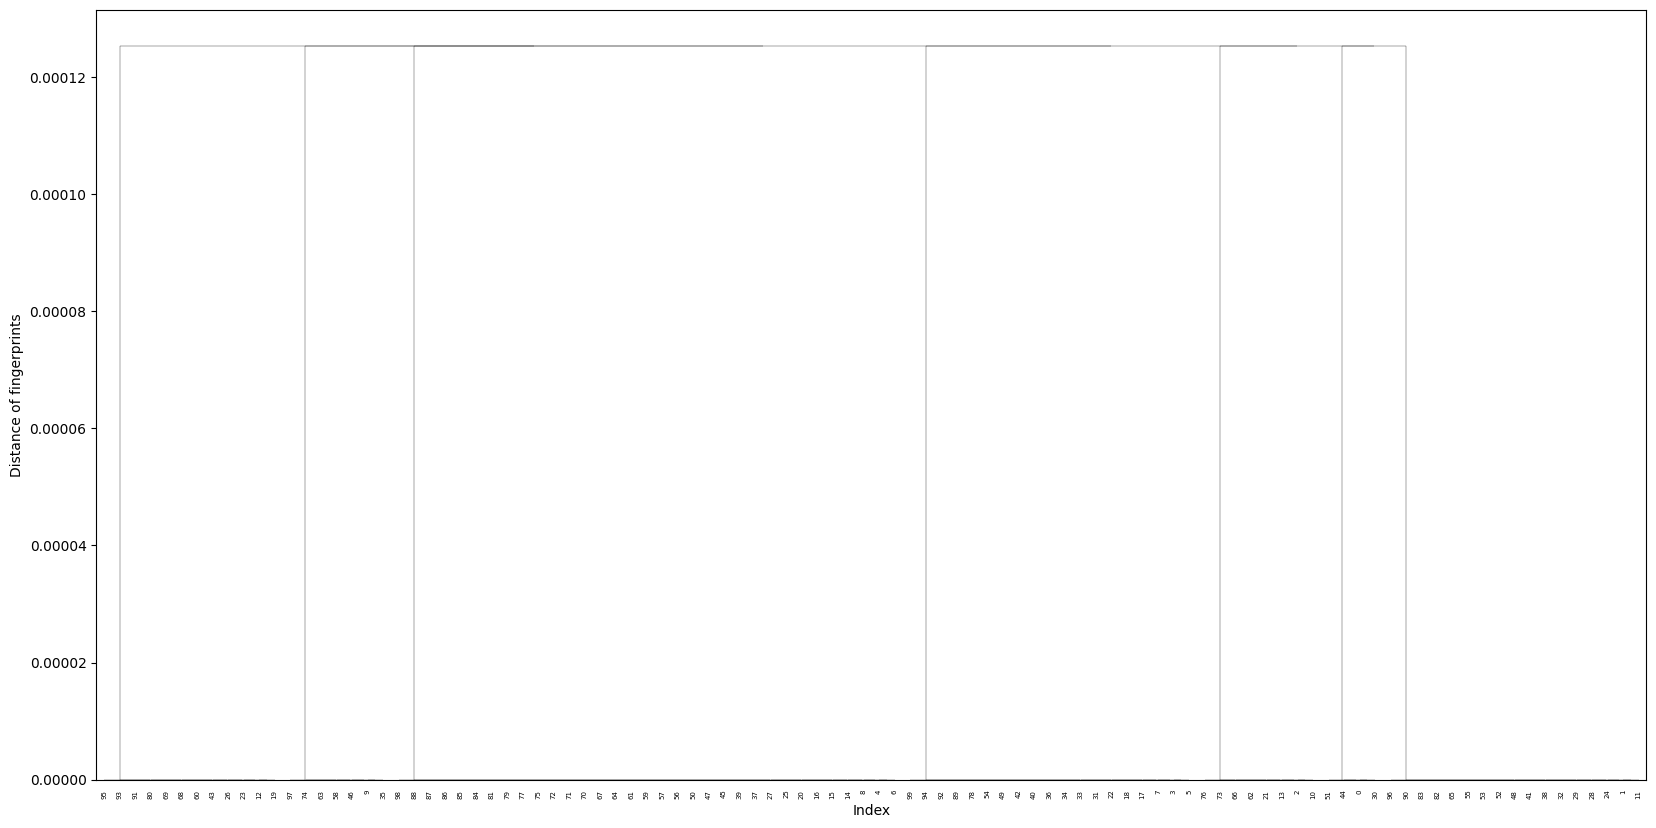

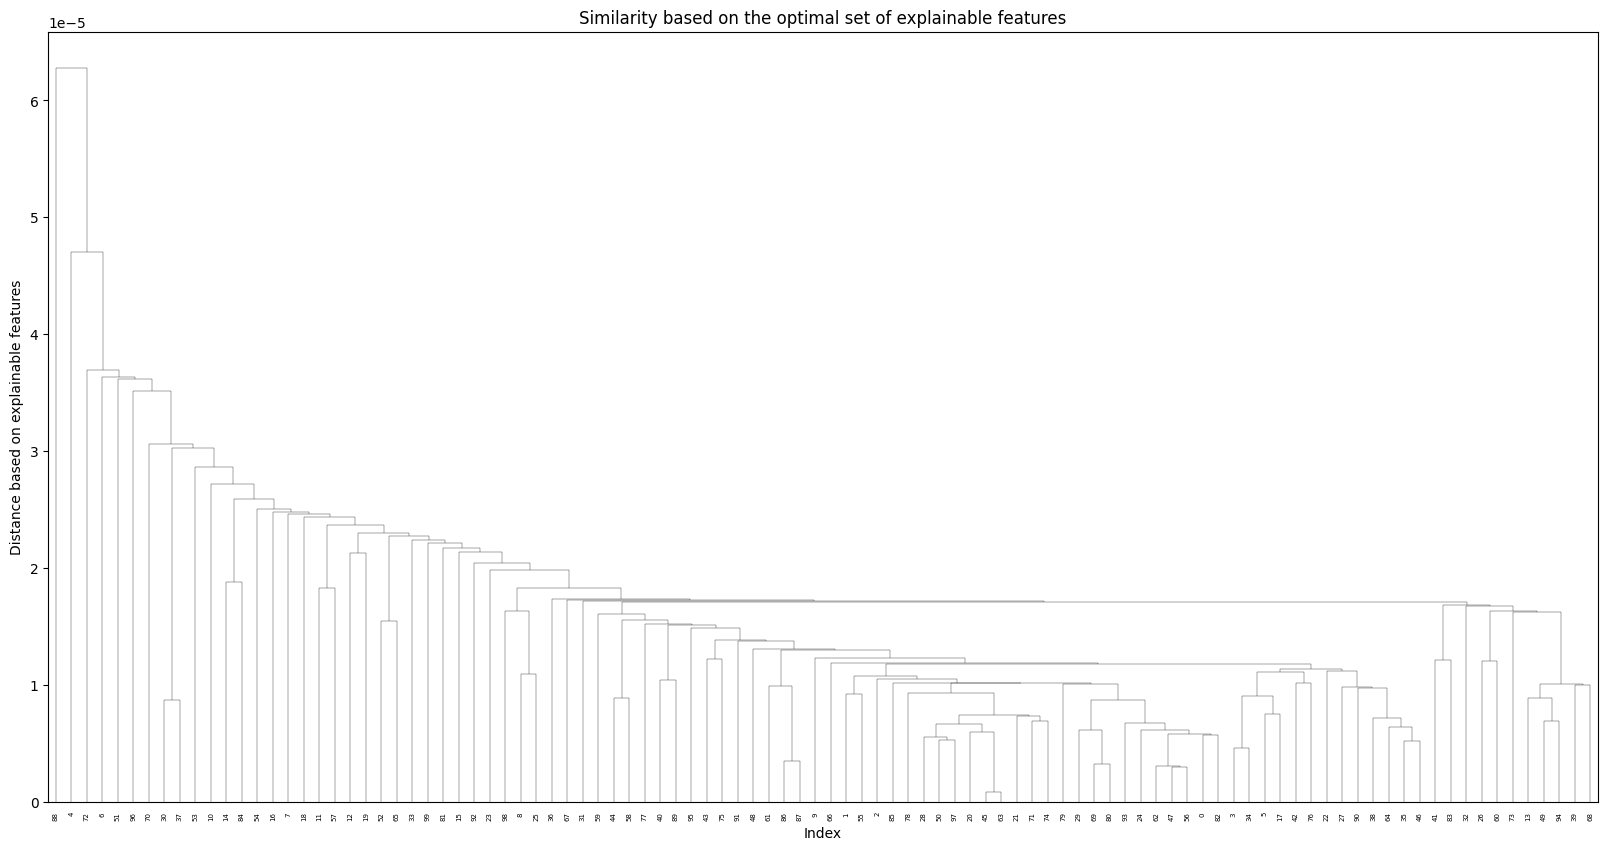

In [ ]:
my_number_of_clusters = optimal_number_of_clusters['n_clusters']
observable_patterns_result = ClusteringApplier.calculate_observable_patterns(
    use_config=False,
    df_observable_data=preparation_result['observable_df'],
    _n_clusters=my_number_of_clusters,
    observable_name='observable_name',
    observable_feature_names=observed_features,
    plot_title='Name of the fingerprint plot',
    number_observable_patterns='auto',
    distance_measure_fingerprint='jensenshannon',
    group_name=index_name, 
    spiderplot_scaling='minmax'
)
calculate_explainable_distances_result = ClusteringApplier.calculate_explainable_distances(
    use_config=False,
    df_explainable=preparation_result['explainable_df'].copy(),
    df_observable_distances=observable_patterns_result['pw_norm_dist'].copy(),
    explaining_features=explaining_features,
    method='exact',
    distance_measure='correlation',
    sparsity_parameter=0.05,
    max_num_threads=12,
    group_name=index_name
)

In [64]:
optimal_number_of_clusters

{'n_clusters': 7, 'knee': np.int64(2), 'elbow': np.int64(2)}

In [65]:
observable_patterns_result['spider_plots']

In [66]:
preparation_result['observable_scaling']

,feature,scaling
0,a,1.0
1,b,1.0
2,c,1.0


In [67]:
calculate_explainable_distances_result.keys()

dict_keys(['overview_df', 'df_explainable_distances', 'dendrogram', 'optimal_feature_set'])

In [68]:
observable_patterns_result.keys()

dict_keys(['df_cluster_median', 'df_observable_data', 'df_fingerprint', 'pw_dist', 'pw_norm_dist', 'spider_plots', 'fingerprint_distance_plots'])

In [69]:
calculate_explainable_distances_result['optimal_feature_set']

[0, 1, 2]

In [71]:
calculate_explainable_distances_result['overview_df']

,correlation,0,1,2,3,4,5
0,0.079316,1,1,1,0,0,0


In [72]:
df_observable_distances = observable_patterns_result['pw_norm_dist']

(<Figure size 1000x500 with 1 Axes>, <Figure size 1000x500 with 1 Axes>)

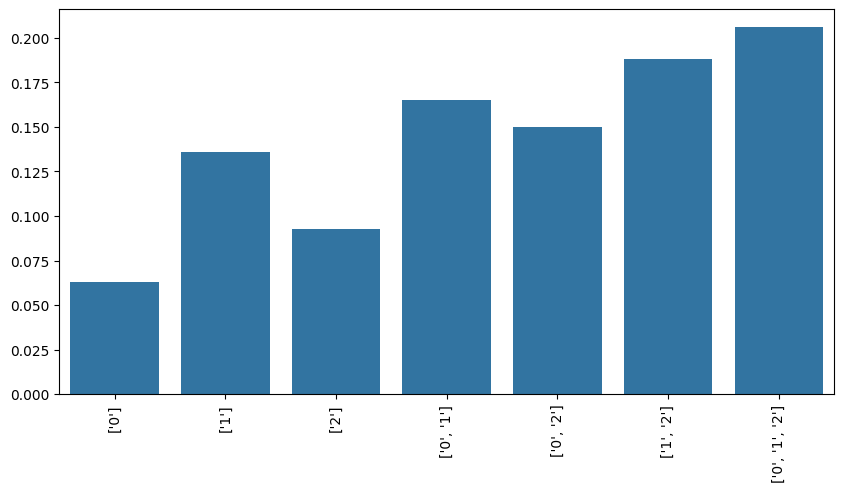

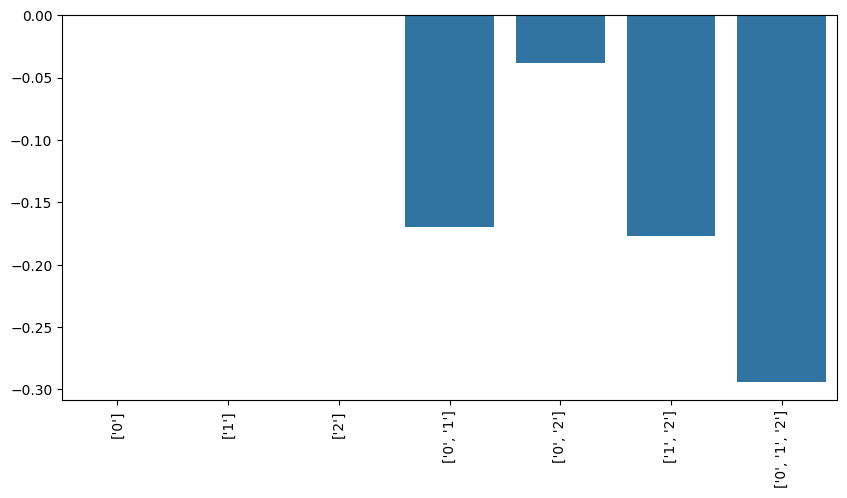

In [57]:
get_feature_importances(
    my_feature_set=calculate_explainable_distances_result['optimal_feature_set'], #explaining_features,
    df_explainable=df_explainable,
    df_observable_distances=df_observable_distances,
    K=100
)

In [42]:
...

Ellipsis

(<Figure size 1000x500 with 1 Axes>, <Figure size 1000x500 with 1 Axes>)

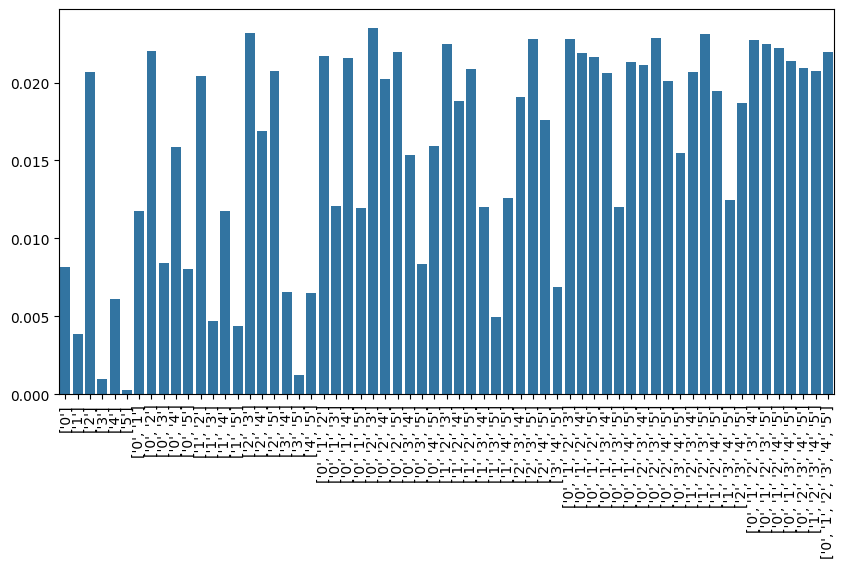

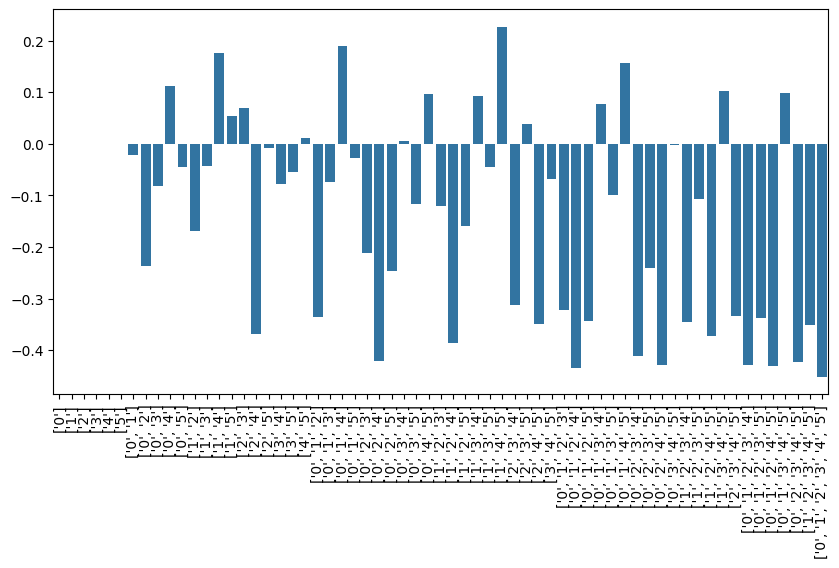

In [62]:
get_feature_importances(
    my_feature_set=explaining_features,
    df_explainable=df_explainable,
    df_observable_distances=df_observable_distances,
    K=100
)

In [48]:
def foo(df_observable, df_explainable, my_feature_set, group_name, K=100):
    obs_df = df_observable.reset_index()
    idx = obs_df.index
    y = df_observable.reset_index().groupby(group_name).mean().to_numpy()
    get_y = lambda: obs_df.loc[permutation(idx)].drop_duplicates(subset=[group_name], keep='first').set_index(group_name).loc[df_explainable.index].to_numpy()

    model = LinearRegression()
    X = df_explainable.loc[:, my_feature_set].to_numpy()
    model.fit(X,y)
    y_pred = model.predict(X)
    R2 = explained_variance_score(y_true=y, y_pred=y_pred)

    feature_importances = defaultdict(lambda: 0.)
    for col_i in range(X.shape[1]):
        for k in range(K):
            permuted_X = X.copy()
            permuted_X[:, col_i] = permutation(permuted_X[:, col_i])
            y = get_y()
            model.fit(X,y)
            R2 = explained_variance_score(y_true=y, y_pred=model.predict(X))
            y_pred = model.predict(permuted_X)
            feature_importances[my_feature_set[col_i]] += (R2 - explained_variance_score(y_true=y, y_pred=y_pred))/K

    adj_sum = sum(feature_importances.values())
    for key, val in feature_importances.items():
        feature_importances[key] = val / adj_sum

    assert np.isclose(sum(feature_importances.values()), 1)

    return feature_importances

In [ ]:
def bar(df_observable, df_explainable, my_feature_set, group_name, penalty_size = 0., K=100):
    obs_df = df_observable.reset_index()
    idx = obs_df.index
    y = df_observable.reset_index().groupby(group_name).mean().to_numpy()
    get_y = lambda: obs_df.loc[permutation(idx)].drop_duplicates(subset=[group_name], keep='first').set_index(group_name).loc[df_explainable.index].to_numpy()

    feature_combinations = []
    ([[feature_combinations.append(np.array(c)) for c in combinations(np.arange(len(my_feature_set)), i)] for i in range(1, len(my_feature_set)+1)])
    
    model = LinearRegression()
    X = df_explainable.loc[:, my_feature_set].to_numpy()
    model.fit(X,y)
    y_pred = model.predict(X)
    R2 = explained_variance_score(y_true=y, y_pred=y_pred)


    feature_importances = defaultdict(lambda: 0.)

    i = 0
    for cols in feature_combinations:
        for k in range(K):
            permuted_X = X.copy()
            for col_i in cols:
                permuted_X[:, col_i] = permutation(permuted_X[:, col_i])
            y = get_y()
            model.fit(X,y)
            R2 = explained_variance_score(y_true=y, y_pred=model.predict(X))
            y_pred = model.predict(permuted_X)
            score = max(0., (R2 - explained_variance_score(y_true=y, y_pred=y_pred))/K)
            feature_importances[i] += max(0, score - (penalty_size*len(cols))/K)
        i += 1

    adj_sum = sum(feature_importances.values())
    for key, val in feature_importances.items():
        feature_importances[key] = val / adj_sum

    assert np.isclose(sum(feature_importances.values()), 1)

    def human_readable(_dict: dict) -> dict:
        return {str([str(a) for a in np.array(my_feature_set)[feature_combinations[k]]]):[v] for k, v in _dict.items()}
    
    human_readable_dict = human_readable(feature_importances)
    max(feature_importances.values())
    fig_1 = plt.figure(figsize=(10, 5))
    ax1 = sns.barplot(human_readable_dict)
    ax1.axes.xaxis.set_tick_params(rotation=90)
    plt.hlines(xmin=0, xmax=len(feature_combinations), y=max(feature_importances.values()) ,linestyles='--')

    revised_feature_importances = defaultdict(lambda: 0)
    i = 0
    for cols in feature_combinations:
            
        a = feature_importances[i]
        b = sum([feature_importances[j] for j in cols])
        revised_feature_importances[i] += a-b #(a/b)-1

        i += 1

    fig_2 = plt.figure(figsize=(10, 5))
    ax2 = sns.barplot(human_readable(revised_feature_importances))
    ax2.axes.xaxis.set_tick_params(rotation=90)

    return fig_1, fig_2

<Axes: >

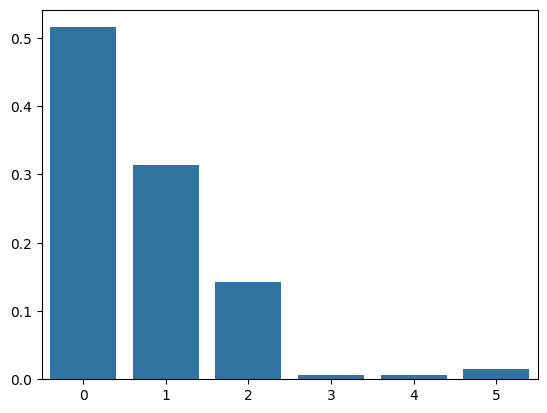

In [106]:
res = foo(preparation_result['observable_df'], preparation_result['explainable_df'], explaining_features, group_name='Index')
sns.barplot(res)

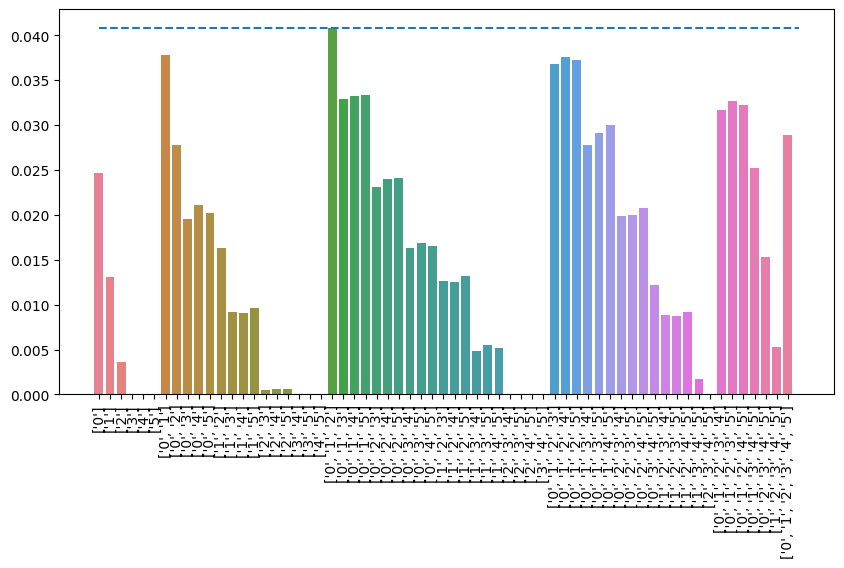

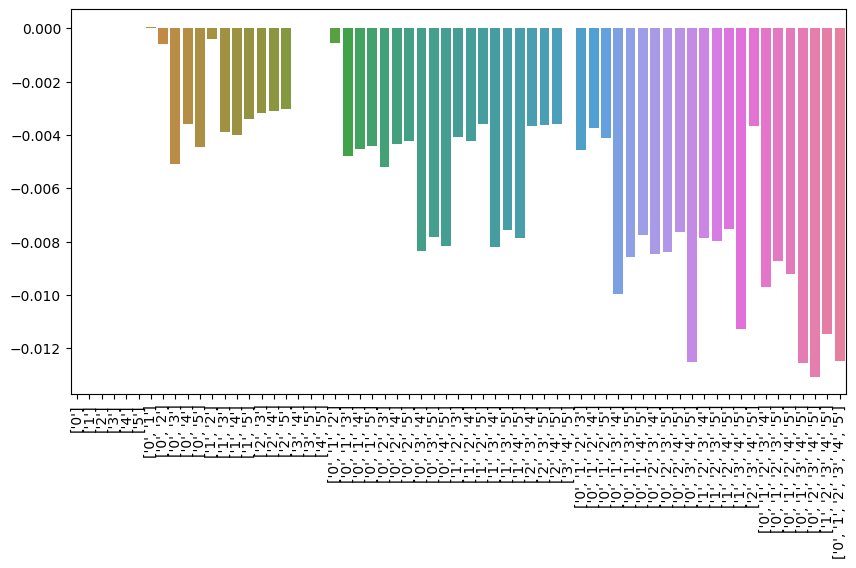

In [134]:
bar_1, bar_2 = bar(preparation_result['observable_df'], preparation_result['explainable_df'], explaining_features, penalty_size = 0.05, group_name='Index')

In [116]:
bar_1.axes[0].tick_params()

In [ ]:
from gradient_solver import FeatureSelectionModel
from ParameterizedModel.training import Trainer
import torch

In [ ]:
df_observable_distances = observable_patterns_result['pw_norm_dist'].copy()
df_explainable = preparation_result['explainable_df'].copy()

model = FeatureSelectionModel(df_explainable.loc[:, explaining_features], df_observable_distances, num_samples=1)

# After this many steps, the learning rate is halved
HALFLIFE = 65

optimizer = torch.optim.RMSprop(
    params = [
        {'params': model.parameters['alpha'], 'lr': 0.1, 'momentum': 0.5},
        {'params': model.parameters['beta'],  'lr': 0.1, 'momentum': 0.5},
    ]
)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)

In [ ]:
trainer = Trainer(model = model, optimizer = optimizer, scheduler = scheduler, dataloader = range(10))
trainer.train(epochs = 300, timeout=120)

1/300 --- Mean Loss : -0.13762383886004836
2/300 --- Mean Loss : -0.20730271477009632
3/300 --- Mean Loss : -0.2111718447198257
4/300 --- Mean Loss : -0.21357065827803529
5/300 --- Mean Loss : -0.21373509900728804
6/300 --- Mean Loss : -0.21440094805578397
7/300 --- Mean Loss : -0.2148656612521741
8/300 --- Mean Loss : -0.21514384772555462
9/300 --- Mean Loss : -0.215251376822067
10/300 --- Mean Loss : -0.21621089638677937
11/300 --- Mean Loss : -0.21539848686113564
12/300 --- Mean Loss : -0.2159068890036735
13/300 --- Mean Loss : -0.21584729805076733
14/300 --- Mean Loss : -0.21549904595924715
15/300 --- Mean Loss : -0.21369436402548417
16/300 --- Mean Loss : -0.21493597968893388
17/300 --- Mean Loss : -0.21536474512412404
18/300 --- Mean Loss : -0.21642431769940434
Timeout


-0.21883757344583332


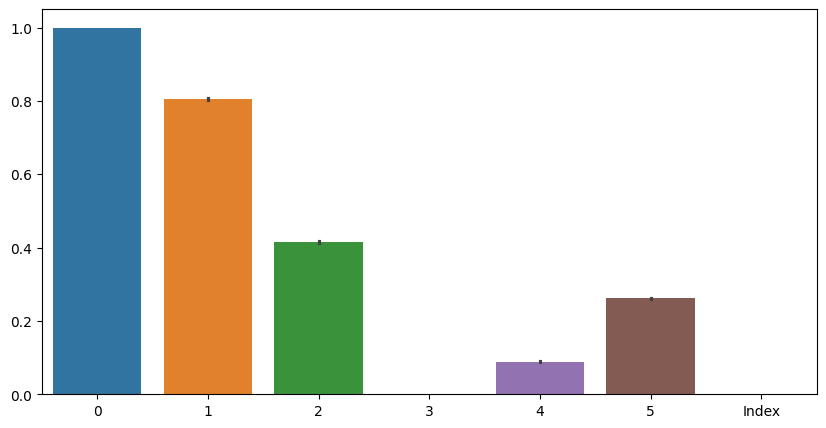

In [ ]:
print(float(model.best_loss))
model.plot()

In [ ]:
...